#### Sentiment Analysis

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt

In [2]:
news_df = pd.read_csv("../data/preprocessed/headlines.csv")
news_df.head()


,Date,Headlines
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t..."
1,2018-03-20,Cramer's charts show 'signs of life' for the s...
2,2018-03-20,Information is 'the modern-day weapon' and we'...
3,2018-03-20,Cramer's lightning round: With so many great b...
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...


In [3]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       51122 non-null  object
 1   Headlines  51122 non-null  object
dtypes: object(2)
memory usage: 798.9+ KB


In [4]:
news_df["Date"] = pd.to_datetime(news_df["Date"])
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       51122 non-null  datetime64[ns]
 1   Headlines  51122 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 798.9+ KB


#### FinBERT

In [5]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#### Now we need to convert the "Headlines" column into lists so we can pass it onto our tokenizer

In [6]:
list_headlines = news_df["Headlines"].tolist()
list_headlines

['Cramer: Trump, the Fed and the cloud can get this market back on track',
 "Cramer's charts show 'signs of life' for the struggling biotech sector",
 "Information is 'the modern-day weapon' and we're always under attack: Shark Tank's Robert Herjavec",
 "Cramer's lightning round: With so many great bank stocks, stay away from Wells Fargo",
 "Cramer Remix: Here's how Mark Zuckerberg should respond to Facebook's crisis",
 'Cramer Remix: Goldman Sachs is the ideal stock to own in this moment of volatility',
 "Cramer: What FedEx's earnings call reveals about Larry Kudlow's views on trade",
 "Cramer's lightning round: Watch the technicals with Canada Goose's stock",
 "Cramer: Facebook's troubles shouldn't weigh on the rest of FANG—or FAANNG",
 "Cramer highlights the value of McDonald's: The current pullback is a 'gift'",
 'The market fell because of the tariffs: Art Cashin',
 'Cramer says fears of artificial intelligence added to the market sell-off',
 "Cramer: This decline isn't about the 

In [7]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    function_to_apply="softmax",       # ensure probabilities
    top_k=None                         # probabilities for all labels
)



Device set to use cpu


Max length: 38
Mean length: 16.4091584836274
95th percentile: 23


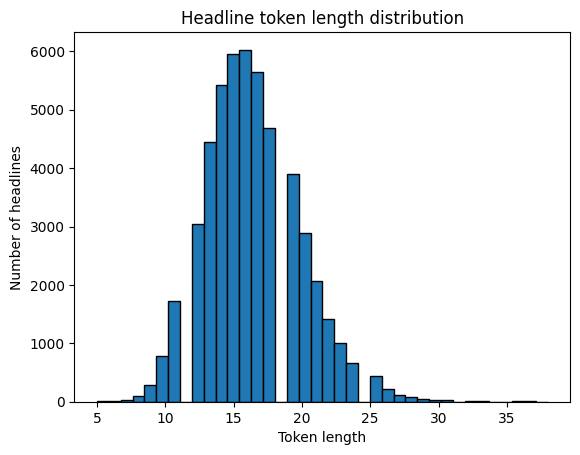

In [8]:
# checking what max_length parameter should be
encodings = tokenizer(
    list_headlines,
    padding=False,
    truncation=False,
    add_special_tokens=True
)

lengths = [len(ids) for ids in encodings["input_ids"]]

print("Max length:", max(lengths))
print("Mean length:", sum(lengths) / len(lengths))
print("95th percentile:", sorted(lengths)[int(0.95 * len(lengths))])

plt.hist(lengths, bins=38, edgecolor='k')
plt.xlabel("Token length")
plt.ylabel("Number of headlines")
plt.title("Headline token length distribution")
plt.show()

In [9]:
finbert_results = finbert(
    list_headlines,
    batch_size=32,
    truncation=True,
    padding=True,
    max_length=64
)


KeyboardInterrupt: 

Results is a list (len == len(list_headlines)), each item is a list of dicts:

[{'label': 'positive', 'score': ...}, 

{'label': 'negative', 'score': ...}, 

{'label': 'neutral', 'score': ...}]

In [ ]:
id2label = model.config.id2label
labels = [id2label[i].lower() for i in range(len(id2label))]  # e.g. ['positive','negative','neutral']


In [ ]:
# map each headline’s list-of-dicts to a dict {label: score}
per_row = []
for row in finbert_results:
    d = {item['label'].lower(): item['score'] for item in row}
    per_row.append(d)

scores_df = pd.DataFrame(per_row)

In [ ]:
for col in ["positive", "neutral", "negative"]:
    if col not in scores_df.columns:
        scores_df[col] = np.nan
        
scores_df = scores_df[["positive", "neutral", "negative"]]

In [ ]:
scores_df["finbert_label"] = scores_df[["positive", "neutral", "negative"]].idxmax(axis=1)
scores_df["finbert_confidence"] = scores_df[["positive", "neutral", "negative"]].max(axis=1)


In [ ]:
# simplest: keep all columns from news_df, add scores
df = news_df.reset_index(drop=True).join(scores_df)

df.head(15)

,headline,positive,neutral,negative,finbert_label,finbert_confidence
0,"Cramer: Trump, the Fed and the cloud can get t...",0.381990,0.606314,0.011696,neutral,0.606314
1,Cramer's charts show 'signs of life' for the s...,0.774735,0.086462,0.138803,positive,0.774735
2,Information is 'the modern-day weapon' and we'...,0.045633,0.888468,0.065899,neutral,0.888468
3,Cramer's lightning round: With so many great b...,0.063592,0.891325,0.045083,neutral,0.891325
4,Cramer Remix: Here's how Mark Zuckerberg shoul...,0.041417,0.937280,0.021303,neutral,0.937280
5,Cramer Remix: Goldman Sachs is the ideal stock...,0.255798,0.734965,0.009238,neutral,0.734965
6,Cramer: What FedEx's earnings call reveals abo...,0.032739,0.934612,0.032649,neutral,0.934612
7,Cramer's lightning round: Watch the technicals...,0.047185,0.932198,0.020618,neutral,0.932198
8,Cramer: Facebook's troubles shouldn't weigh on...,0.034917,0.681942,0.283141,neutral,0.681942
9,Cramer highlights the value of McDonald's: The...,0.808084,0.179881,0.012034,positive,0.808084


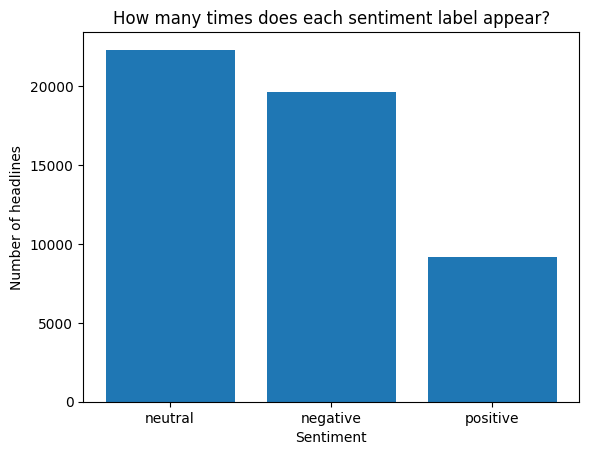

In [ ]:
label_counts = df["finbert_label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.title("How many times does each sentiment label appear?")
plt.xlabel("Sentiment")
plt.ylabel("Number of headlines")
plt.show()


Comparing it to the previous setup of FinBERT I tried

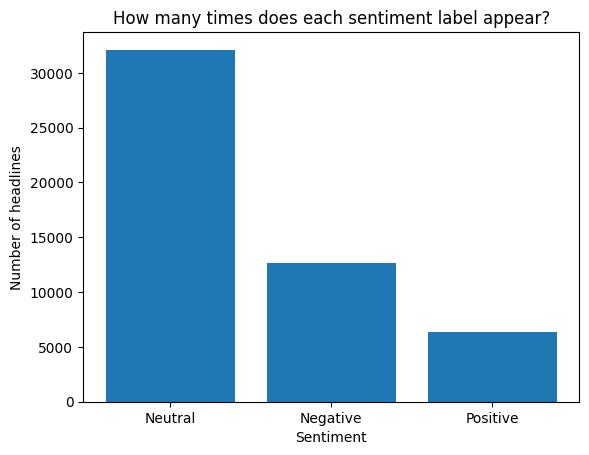

In [ ]:
test_data = pd.read_csv("../data/preprocessed/news_with_sentiment.csv")

label_counts = test_data["finbert_label"].value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.title("How many times does each sentiment label appear?")
plt.xlabel("Sentiment")
plt.ylabel("Number of headlines")
plt.show()

I believe the difference comes from the change in label mapping. In the earlier version I basically hard-coded the labels:

labels = ["positive", "negative", "neutral"], which didn't match FinBERT's actual 1d2label order, so many predictions got mislabeled.

In [ ]:
df.to_csv("../data/preprocessed/headlines_finbert.csv", index=False)